In [1]:
from scalability_testing import *
import re
import pandas as pd
import csv
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf, lower, count, regexp_replace
from pyspark.sql.types import StringType, IntegerType
from collections import Counter

In [2]:
def sentiment_analysis(df):

    botlist_path="/home/ubuntu/DEI-project/preprocessing/preprocessing files/botlist.csv"
    positive_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/positive_words.csv"
    negative_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/negative_words.csv"

    ############################# Pre Processing #############################
    # Select relevant columns
    df = df.select("author", "subreddit", "normalizedBody")

    # Load bot list
    bot_df = pd.read_csv(botlist_path)
    bot_list = bot_df["AAbot"].dropna().unique().tolist() 

    # Remove bot-generated comments
    df_filtered = df.filter(~col("author").isin(bot_list))

    df_filtered = df_filtered.filter(col("normalizedBody").isNotNull())

    # lower case, remove special characters and digits
    df_cleaned = df_filtered.withColumn(
        "normalizedBody",
        lower(regexp_replace(regexp_replace(col("normalizedBody"), r'[^\w\s]', ''), r'\d+', ''))
    )

    # dropt author column
    df_cleaned = df_cleaned.drop("author")
    
    ############################ Sentiment Analysis ############################
    def load_words_from_csv(filepath):
        with open(filepath, "r") as file:
            lines = file.read().splitlines()  # read all lines at once
        
        lines = lines[1:]  # skip header

        return set(word.strip() for word in lines if word)  # remove empty lines

    positive_words = load_words_from_csv(positive_words_file)
    negative_words = load_words_from_csv(negative_words_file)

    # Define sentiment analysis function
    def analyze_sentiment(text):
        if not text:
            return 0 # neutral
        words = text.lower().split()

        # dictionary with word counts
        word_counts = Counter(words)
    
        # Count positive and negative words using intersection with the word counts
        pos_count = sum(word_counts[word] for word in words if word in positive_words)
        neg_count = sum(word_counts[word] for word in words if word in negative_words)

        # labeling with integers to simplify postive-to-negative calculations
        if pos_count > neg_count:
            return 1 # positive
        elif neg_count > pos_count:
            return -1 # negative
        return 0 # neutral
    
    # Register UDF
    sentiment_udf = udf(analyze_sentiment, IntegerType())

    # Apply sentiment analysis
    df_result = df_cleaned.withColumn("sentiment", sentiment_udf(col("normalizedBody")))
    
    ################## Finding Top 5 Positive/Negative Subreddits #####################
    # group by subreddit and count total posts and sum of sentiment. filter out subreddits with few posts
    df_sentiment = df_result.groupBy("subreddit").agg(
        count("*").alias("total_posts"),
        F.sum(col("sentiment")).alias("sentiment_sum")
    ).filter(col("total_posts") > 50)

    # compute sentiment ratio (sentiment_sum / total_posts)
    df_sentiment = df_sentiment.withColumn(
        "sentiment_ratio", col("sentiment_sum") / col("total_posts")
    )

    # get top 5 most positive and most negative subreddits
    df_sentiment = df_sentiment.orderBy(col("sentiment_ratio").desc())
    top_positive = df_sentiment.limit(5)
    top_negative = df_sentiment.orderBy(col("sentiment_ratio").asc()).limit(5)

    return df_result, top_positive, top_negative

## Top 5 most positive/negative subreddits
    - based on (positve_posts - negative_posts)/total_posts

In [ ]:
spark_session = create_spark_session(num_workers=3)
spark_context = spark_session.sparkContext
sqlContext = SQLContext(spark_context)

df = sqlContext.read.json("hdfs://192.168.2.46:9000/data/corpus-webis-tldr-17.json")

In [7]:
_, top_positive, top_negative = sentiment_analysis(df)
top_positive.show()
top_negative.show()

+-------------+-----------+-------------+------------------+
|    subreddit|total_posts|sentiment_sum|   sentiment_ratio|
+-------------+-----------+-------------+------------------+
|   DankNation|        441|          408|0.9251700680272109|
|     Sexsells|         58|           49|0.8448275862068966|
|BDSMpersonals|         80|           65|            0.8125|
|    ESOGuilds|         71|           57|0.8028169014084507|
|         love|        127|           99|0.7795275590551181|
+-------------+-----------+-------------+------------------+



[Stage 4:======================================================>(146 + 1) / 147]

+----------+-----------+-------------+--------------------+
| subreddit|total_posts|sentiment_sum|     sentiment_ratio|
+----------+-----------+-------------+--------------------+
|     Anger|        101|          -42| -0.4158415841584158|
|    eczema|        124|          -36| -0.2903225806451613|
|misophonia|        130|          -34|-0.26153846153846155|
|vaginismus|         57|          -14|-0.24561403508771928|
|      Endo|        121|          -29| -0.2396694214876033|
+----------+-----------+-------------+--------------------+



In [8]:
spark_session.stop()

## Horizontal scalability test
    - experiment ran with 1-4 workers and 8 cores per worker

In [3]:
from scalability_testing import *
exc_times = []
data_load_times = []
processing_times = []
workers = [1, 2, 3, 4] 
for num_workers in workers:
    execution_time, data_load_time, processing_time = scalability_test(job=sentiment_analysis, num_workers=num_workers)
    exc_times.append(execution_time)
    data_load_times.append(data_load_time)
    processing_times.append(processing_time)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/13 17:57:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 1 workers completed in 761.98 sec
Time to load in data: 332.74 sec
Time to perform data processing task: 429.25 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 2 workers completed in 514.08 sec
Time to load in data: 214.75 sec
Time to perform data processing task: 299.34 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 3 workers completed in 482.76 sec
Time to load in data: 258.11 sec
Time to perform data processing task: 224.65 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 4 workers completed in 354.92 sec
Time to load in data: 197.99 sec
Time to perform data processing task: 156.94 sec


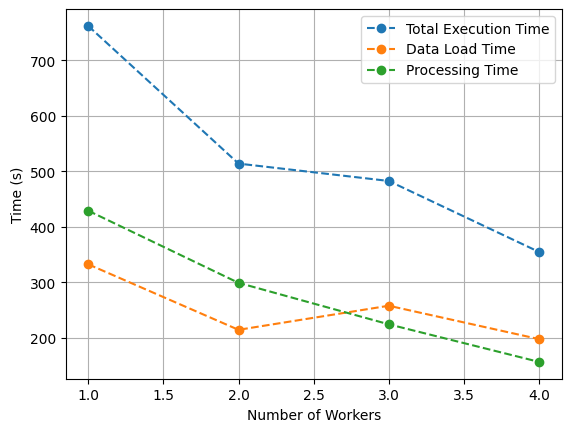

In [7]:
import matplotlib.pyplot as plt

plt.plot(workers, exc_times, 'o--', label="Total Execution Time")
plt.plot(workers, data_load_times, 'o--', label="Data Load Time")
plt.plot(workers, processing_times, 'o--', label="Processing Time")
plt.xlabel("Number of Workers")
plt.ylabel("Time (s)")
plt.legend()
plt.grid()
plt.show()